In [17]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob, os
import torch
import numpy as np

import seaborn as sns
import config_matplotlib
config_matplotlib.config_matplotlib()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

registered cmap: seaborn_cubehelix



In [18]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [19]:
steps_of_interest = [25, 50]

In [24]:
mean_preds = []
true_values = []
sample_ids = []
maes = []


measured_angles = []
method = 'poisson_scaled_nonunique_optimal'

for path in summary_dict['real'][method]:
    pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
    pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

    for _idx, _idx in enumerate(pt_indices):
        _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx:02d}.pt'))
        # print(_pt.keys())
        _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
        
        # _mean_preds = _pt['means']
        
        # _maes = (_mean_preds - _pt['true_params'][None]).norm(dim=-1)
        # maes.append(_maes[steps_of_interest].unsqueeze(0))
        _maes = (_mean_preds - _pt['true_params'][None])[-1,None].abs()
        
        maes.append(_maes)
        mean_preds.append(_mean_preds.unsqueeze(0))
        sample_ids.append(_idx)
        true_values.append(_pt['true_params'])
        measured_angles.append(_pt['measured_angles'].unsqueeze(0))
        
maes = torch.vstack(maes).numpy()
mean_preds = torch.vstack(mean_preds).numpy()
sample_ids = torch.tensor(sample_ids).numpy()
true_values = torch.vstack(true_values).numpy()
measured_angles = torch.vstack(measured_angles).numpy()

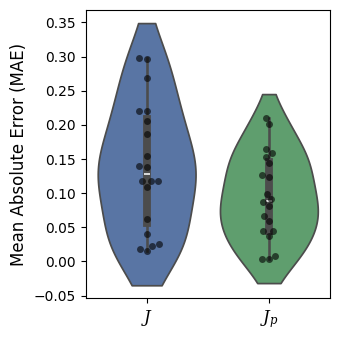

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
sns.violinplot(data=maes, ax=ax, cut=True)
sns.swarmplot(data=maes, ax=ax, color='black', alpha=0.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)')

fig.tight_layout()
fig.savefig('figures/mae_violin_nonunique.pdf', dpi=300)

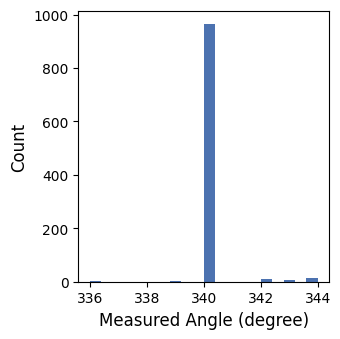

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
plt.hist(measured_angles.flatten(), bins=20);
ax.set_xlabel('Measured Angle (degree)')
ax.set_ylabel('Count')
fig.tight_layout()
fig.savefig('figures/measured_angle_hist_nonunique.pdf', dpi=300)